In [ ]:
%matplotlib inline
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.observation import Observation, ObservationLong
from karabo.simulation.visibility import Visibility

from oskar.imager import Imager
import numpy as np, os, sys, pandas as pd, toml
import tools21cm as t2c
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import astropy.units as u
import astropy.constants as cst

from astropy.io import fits
from astropy.wcs import WCS
from astropy.cosmology import Planck18
from astropy.coordinates import Angle

from utils.smoothing import smoothing_grid
from atmos_effect.create_screen import simulate_TEC

## Parameters & Flags
I/O paths and Flag option to switch on/off primary beam effect and ionospheric effect.

In [60]:
path_in = './'
path_out = '/scratch/snx3000/mibianco/'

path_telescope = '/store/ska/sk05/mibianco/telescope.tm'

fname = 'syngf_ch600_1024.fits'
run_name = path_out+fname.replace('.fits', '')

PBEAM = False
ION = False

## Define Sky Model
Provided that you data are stored in a _*.fits_ file. To create a simple input file look at the script _create_fits.ipynb_

In [75]:
with fits.open(path_in+fname, mode="readonly", memmap=True) as hdulist:
    hdr = hdulist[0].header

    FoV = hdr['CDELT2']*Nx * u.Unit(hdr['CUNIT2'])
    Nx, Ny = hdr['NAXIS1'], hdr['NAXIS2']
    
    dthet = FoV / Nx
    
    RA, DEC = hdr['CRVAL1']*u.Unit(hdr['CUNIT1']), hdr['CRVAL2']*u.Unit(hdr['CUNIT2'])
    
    dfreq = hdr['CDELT3'] * u.Unit(hdr['CUNIT3'])
    freq = hdr['CRVAL3'] * u.Unit(hdr['CUNIT3'])
    z = t2c.nu_to_z(freq.to('MHz').value)

    data = hdulist[0].data * u.Unit(hdr['BUNIT'])
    
    w = WCS(hdr).celestial

print(' freq = %.5e %s, z = %.3f' %(freq.value, freq.unit, z))
print(' FoV = %.2f %s' %(FoV.value, FoV.unit))
print(' RA, DEC = (%.3f, %.3f) %s' %(RA.value, DEC.value, DEC.unit))

 freq = 1.66000e+08 Hz, z = 7.554
 FoV = 13.04 deg
 RA, DEC = (0.000, -30.000) deg


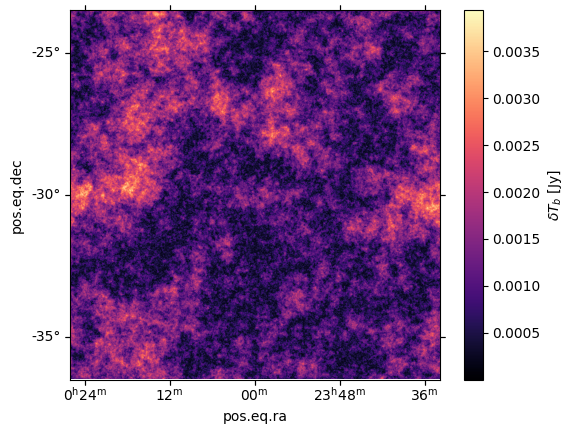

In [36]:
plt.subplot(projection=w)
plt.imshow(data.value, cmap='magma')
plt.colorbar(label=r'$\delta T_b$ [%s]' %data.unit)

## Create sky model for OSKAR
the data requires the following columns structure:<br/>
RA [deg], Dec [deg], I [Jy], Q [Jy], U [Jy], V [Jy], ref freq [Hz], alpha, rot, maj ax [arcsec], min ax [arcsec], pos angle [deg], object ID


In [16]:
# get coordinates
idx_ra, idx_dec = np.arange(0, Nx).reshape(Nx, 1), np.arange(0, Ny).reshape(1, Ny)
lon, lat = w.celestial.all_pix2world(idx_ra, idx_dec, 1)
sky_grid =  np.vstack((lon[np.newaxis, ...], lat[np.newaxis, ...])).reshape(2,lon.shape[0]*lon.shape[1]).T

# use only non-zero grid points
idx_nozero = np.nonzero(data.value.flatten())[0]

# create sky model
sky_data = np.zeros((idx_nozero.size, 13))
sky_data[:,:3] = np.hstack((sky_grid[idx_nozero, :], data.value.flatten()[idx_nozero, np.newaxis]))
sky_data[:,9] += 2*FoV.to('arcsec').value/Nx
sky_data[:,10] += 2*FoV.to('arcsec').value/Nx
sky = SkyModel(sky_data)

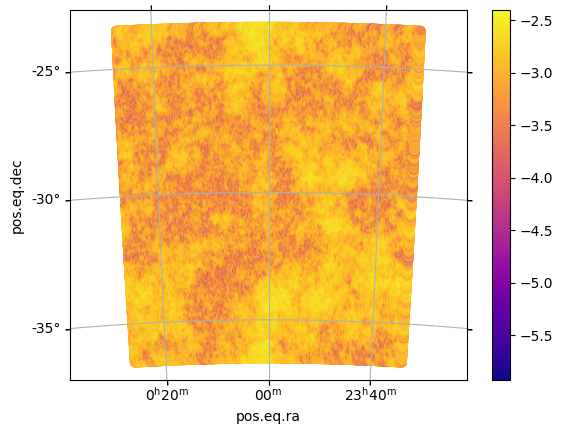

In [40]:
sky.explore_sky(phase_center=[0, -30])#, xlim=[0.1, -0.1], ylim=[-32, -28])

    path_beam = '/store/ska/sk05/mibianco/station_beam.fits'
    beam_data = fits.getdata(path_beam)
    beam_hdr = fits.getheader(path_beam)## Include Primary Beam Effect
<u>Remark:</u> at the moment there is a bug in the OSKAR pipeline when applying the primary beam from a <i>*.fits</i> file.<br>As a quick fix we apply the primary beam by multiply it directly the sky model (created with <a href="https://everybeam.readthedocs.io/en/latest/">EveryBeam</a> library)

In [6]:
if(PBEAM):
    # get and apply primary beam
    path_beam = '/store/ska/sk05/mibianco/station_beam.fits'
    beam_data = fits.getdata(path_beam)
    beam_hdr = fits.getheader(path_beam)
    w_beam = WCS(hdr).celestial

    smooth_primary_beam = smoothing_grid(arr=beam_data[idx_f], noc=Nx, opt='mean')
    data *= smooth_primary_beam

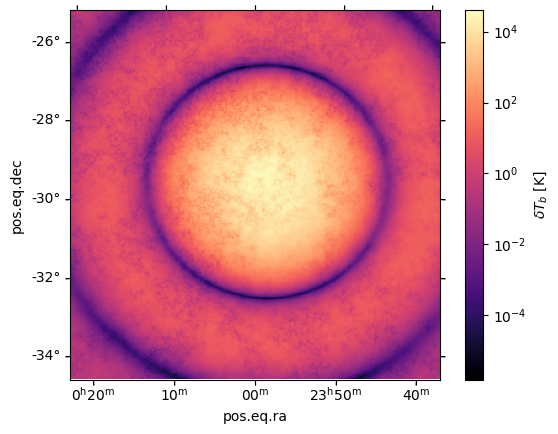

In [17]:
plt.subplot(projection=w)
plt.imshow(data/beam_sim, cmap='magma', norm ='log')
plt.colorbar(label=r'$\delta T_b$ [K]')

## Setup the Observation

In [62]:
telescope = Telescope.read_from_file(path_telescope)

t_start = datetime(2021, 9, 21, 14, 12, 40, 0) # HA between -2h to +2h, obs start at '2021-09-21 14:12:40.1'

# set to 1 minute just for testing (for SKA-Low is 4 hours)
t_obs = timedelta(hours=0, minutes=1, seconds=0, milliseconds=0)
t_day = t_obs

t_int = timedelta(seconds=10)
nr_tsteps = int(t_day.total_seconds() / t_int.total_seconds())
nr_days_obs = int(t_obs.total_seconds() / t_day.total_seconds())

print(' Simulating %d days observation\n time steps: %d' %(nr_days_obs, nr_tsteps))

observation_settings = Observation(phase_centre_ra_deg=RA.value,
                                        phase_centre_dec_deg=DEC.value,
                                        start_date_and_time=t_start,
                                        start_frequency_hz=freq.value,
                                        number_of_channels=1,
                                        number_of_time_steps=nr_tsteps,
                                        length=t_day)

simulation = InterferometerSimulation(ms_file_path=run_name+'.MS',
                                        vis_path=run_name+'.vis',
                                        use_gpus=True, use_dask=False,
                                        channel_bandwidth_hz=dfreq.value,
                                        noise_enable=False)

 Simulating 1 days observation
 time steps: 6


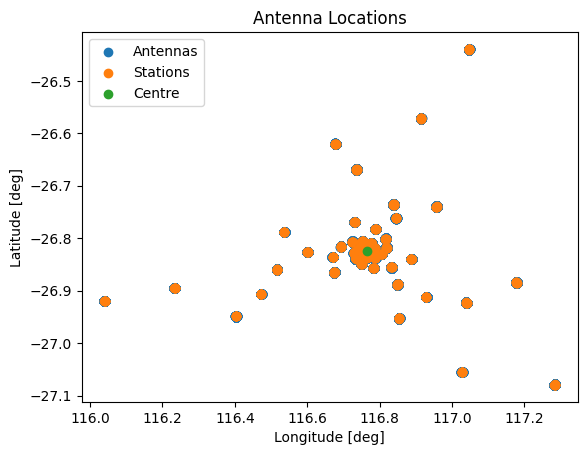

In [63]:
telescope.plot_telescope()

## Run OSKAR simulation

In [64]:
visibilities = simulation.run_simulation(telescope, sky, observation_settings)

Saved visibility to /scratch/snx3000/mibianco/syngf_ch600_1024.vis


## Make Image an image with OSKAR

In [76]:
imager = Imager('single')
imager.set(fov_deg=FoV.to('deg').value, image_size=1024)
imager.set(input_file=run_name+'.vis', output_root=run_name)
output = imager.run(return_images=1)
image = output["images"][0]

new_w = WCS(naxis=2)
new_w.wcs.crpix = [512, 512]
#new_w.wcs.cdelt = np.array([-0.0044444444, 0.0044444444])
new_w.wcs.cdelt = np.array([-dthet.to('arcmin').value, dthet.to('arcmin').value])
new_w.wcs.crval = [0, -30]
new_w.wcs.ctype = ["RA---SIN", "DEC--SIN"]

W|                                                                   
W|== WARNING: Skipped 407120 visibility points.
W|                                                                   


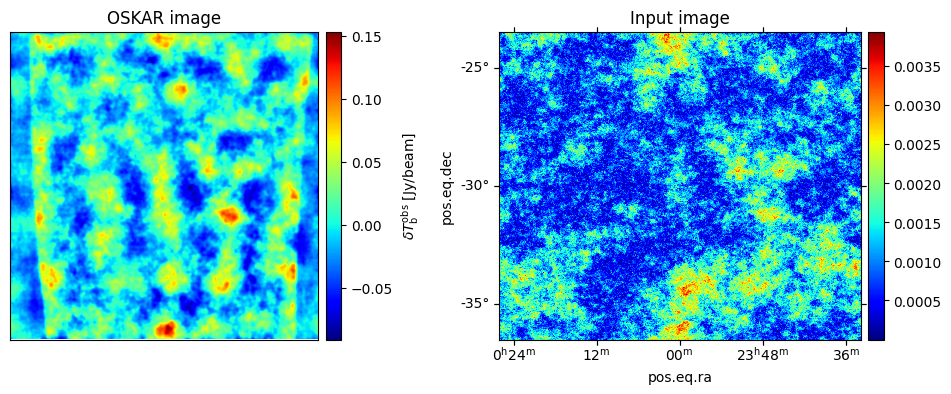

In [77]:
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(hspace=2, wspace=0.4)

x, y = np.arange(0, data.shape[0], 1), np.arange(0, data.shape[0], 1)

ax0 = fig.add_subplot(1, 2, 1, projection=new_w)
ax0.set_title("OSKAR image")
im = ax0.imshow(image, cmap="jet")
plt.colorbar(im, ax=ax0, label=r"$\delta T^{\rm obs}_{\rm b}$ [Jy/beam]", pad=0.02, fraction=0.048)

ax1 = fig.add_subplot(1, 2, 2, projection=w)
ax1.set_title("Input image")
im = ax1.pcolormesh(x, y, data.T, cmap="jet")
plt.colorbar(im, ax=ax1, pad=0.02, fraction=0.048)

# Add Direction Independent (DI) Gain Error

In [16]:
import numpy as np, os, gc, random, sys
import casacore.tables as tb

from tqdm import tqdm
from time import time
from datetime import timedelta

from gain.di.utils_gain import calculate_SDC3_gains
from gain.di.calculate_gain import DIAntennaErrorSDC3A, DIBaselineErrorSDC3A

Copy the Measerement Set for safety

In [17]:
ms_input = '/scratch/snx3000/mibianco/output_sdc3/dataLC_256_train_090523/test/lc_256_train_090523_i0_dT_test_ch600_4h1d_301.MS'
ms_output = ms_input.replace('dT', 'dTgain')

if not (os.path.exists(ms_output)):
    os.system('cp -r %s %s' %(ms_input, ms_output))
else:
    print(' folder %s exist... over-writing to MODEL_DATA.' %ms_input)

 folder /scratch/snx3000/mibianco/output_sdc3/dataLC_256_train_090523/test/lc_256_train_090523_i0_dT_test_ch600_4h1d_301.MS exist... over-writing to MODEL_DATA.


Read the copied Measurement Set

In [18]:
start_time = time()

# Open the MeasurementSet
ms = tb.table(ms_output, ack=False, readonly=False)

# Get visibility
vis_data = ms.getcol('DATA')
print(f"Get visibility data : {timedelta(seconds=time()-start_time)}")
get_time = time()
print("------------------------------------------------")

# Get the number of frequency channels
frequency = ms.SPECTRAL_WINDOW.CHAN_FREQ[:]
num_chan = frequency[0].size

# Get the unique antenna IDs, number of antennas and baselines
ant1 = ms.getcol('ANTENNA1')
ant2 = ms.getcol('ANTENNA2')
antennas = np.unique(np.concatenate((ant1, ant2)))
num_antennas = len(antennas)
num_baselines = int(num_antennas * (num_antennas - 1) / 2)
del ant1, ant2, antennas

# Get the number of time steps
times = ms.getcol('TIME')
num_times = len(np.unique(times))
del times

# garbage collector
gc.collect()
print(f" Get unique time and antennas : {timedelta(seconds=time()-get_time)}")
get_time = time()

Get visibility data : 0:00:00.027629
------------------------------------------------
 Get unique time and antennas : 0:00:00.161068


# Combine gain error to visibility data
in our case we consider a gain of the form: 
$$(1 + q_i) = (A_it\cdot exp^{2\pi \cdot i \cdot B_t }) \cdot (A_if \cdot exp^{2\pi \cdot i \cdot B_f}))$$

in our case we define the 

 DI Antenna Error


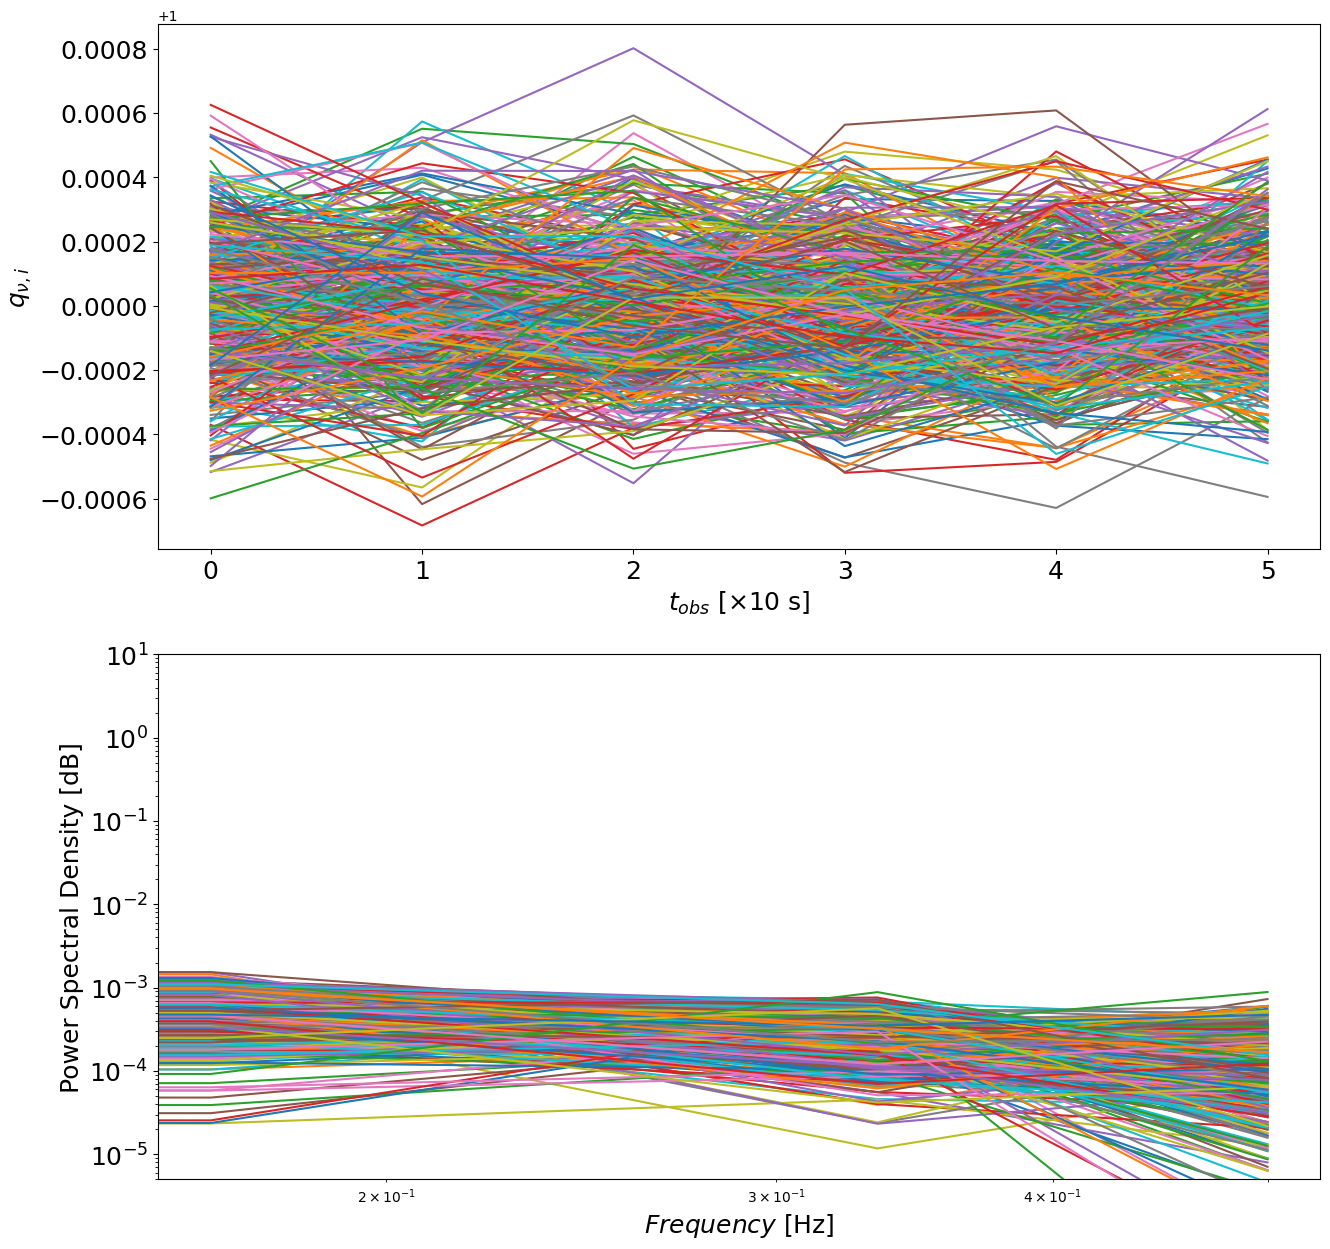

 DI Baseline Error
Loop took : 0:00:00.031232
Reshape took : 0:00:00.000066
 Apply gains to visibility : 0:00:04.581184


In [19]:
amp_mean, amp_sig = 1, 2e-4
pahse_mean, phase_sig = 0, 0.02*np.pi/180
rseed = random.randint(0, 1e9)

print(' DI Antenna Error')
antennaErrorSKALow = DIAntennaErrorSDC3A(numAntenna=num_antennas, frequencyChannels=np.array([frequency]), timeSteps=num_times)

print(' DI Baseline Error')
gain_matrix = DIBaselineErrorSDC3A(gainMatrix = antennaErrorSKALow)
gain = gain_matrix.reshape(gain_matrix.shape[0]*gain_matrix.shape[1], gain_matrix.shape[2], 1) # Now Ntimes*Nbaselines, Nchannels
gain_vid_data = (gain*vis_data).reshape(num_times*num_baselines, 1, 4)

print(f" Apply gains to visibility : {timedelta(seconds=time()-start_time)}")
get_time = time()


Add the MODEL_DATA column to the table and copy DATA values

In [20]:
try:
    data_desc = ms.getcoldesc('DATA')
    data_desc['name'] = 'MODEL_DATA'
    ms.addcols(desc=data_desc)
except:
    print(' column data MODEL_DATA already exist... Over-writing data.')

ms.putcol('MODEL_DATA', gain_vid_data)

# Close the MeasurementSet
ms.close()

print(f" gain effect written in MS: {timedelta(seconds=time()-get_time)}")
print(f" Total time :            {timedelta(seconds=time()-start_time)}")

 column data MODEL_DATA already exist... Over-writing data.
 gain effect written in MS: 0:00:00.375420
 Total time :            0:00:04.956792


# Add Systematic Noise
We assume a tracked scan of $t_{daily} = 6\,h/day$, $t_{int} = 10\, s$ integration time, and a total $t_{obs} = 1000\, h$ measurement.<br>
The standard deviation noise for each baseline and frequency channel of width $\Delta\nu_c$ is then (for single polarization): 

$$ \sigma_{uv} = \frac{T_{sys}}{\sqrt{2\Delta\nu_c t_{int}}}\cdot \sqrt{\frac{t_{daily}}{N_{uv}\cdot t_{obs}}} $$


In [26]:
import numpy as np, os, dask.array as da, random, sys, gc
import casacore.tables as tb

from daskms import xds_from_table
from time import time
from datetime import timedelta

import sys
from noise.calculate_noise import add_noise, read_SEFD, write_vis, get_vis

In [30]:
start_time = time()

ms_input = '/scratch/snx3000/mibianco/output_sdc3/dataLC_256_train_090523/test/lc_256_train_090523_i0_dT_test_ch600_4h1d_301.MS'
ms_output = ms_input.replace('dT', 'dTnoise')

if not (os.path.exists(ms_output)):
    os.system('cp -r %s %s' %(ms_input, ms_output))
else:
    #raise FileExistsError(' %s do not exist. Stopping.' %ms_input)
    print(' folder %s exist.' %ms_output)

# define noise parameters
n_days = 250
SEFD_path = '/store/ska/sk014/dataset_sdc3/inputs/SEFD_tables/AAVS2_sensitivity_ra0.00deg_dec_-30.00deg_0.00hours.txt'
rseed = random.randint(0, 1e9)
write_col = 'DATA'

# allocate MS with Dask
ds = xds_from_table(ms_input, chunks={'row': 511*256*10, 'chan': 1, 'corr': 4, 'uvw': 3})[0]
print(f" MS file loaded in :     {timedelta(seconds=time()-start_time)}")
get_time = time()

# calculate noise
SEFD = read_SEFD(SEFD_path)
vis = get_vis(ms_input, write_col)
noisy_vis = add_noise(vis, SEFD/da.sqrt(n_days), ms_input, ds, seed=rseed)

print(f" Noise applied in :      {timedelta(seconds=time()-get_time)}")
get_time = time()

# free memory
del ds, vis
gc.collect()

# apply noise and gain to visibility of new measurment set
ms = tb.table(ms_output, ack=False, readonly=False)
ms.putcol('DATA', noisy_vis.values)
ms.close()

print(f" MS file written in :    {timedelta(seconds=time()-get_time)}")
print(f" Total time :            {timedelta(seconds=time()-start_time)}")

 folder /scratch/snx3000/mibianco/output_sdc3/dataLC_256_train_090523/test/lc_256_train_090523_i0_dTnoise_test_ch600_4h1d_301.MS exist.
 MS file loaded in :     0:00:00.034360
 Noise applied in :      0:00:00.310382
 MS file written in :    0:00:00.382998
 Total time :            0:00:00.728104


## Visual comparison of Noise and Gain effect

In [42]:
from utils.utils_plot import MidpointNormalize

In [43]:
path_in = '/scratch/snx3000/mibianco/output_sdc3/dataLC_256_train_090523/test/'

data = fits.getdata(path_in+'lc_256_train_090523_i0_dT_test_ch600_4h1d_301-dirty.fits').squeeze()
data_gain = fits.getdata(path_in+'lc_256_train_090523_i0_dTgain_test_ch600_4h1d_301-dirty.fits').squeeze()
data_noise = fits.getdata(path_in+'lc_256_train_090523_i0_dTnoise_test_ch600_4h1d_301-dirty.fits').squeeze()

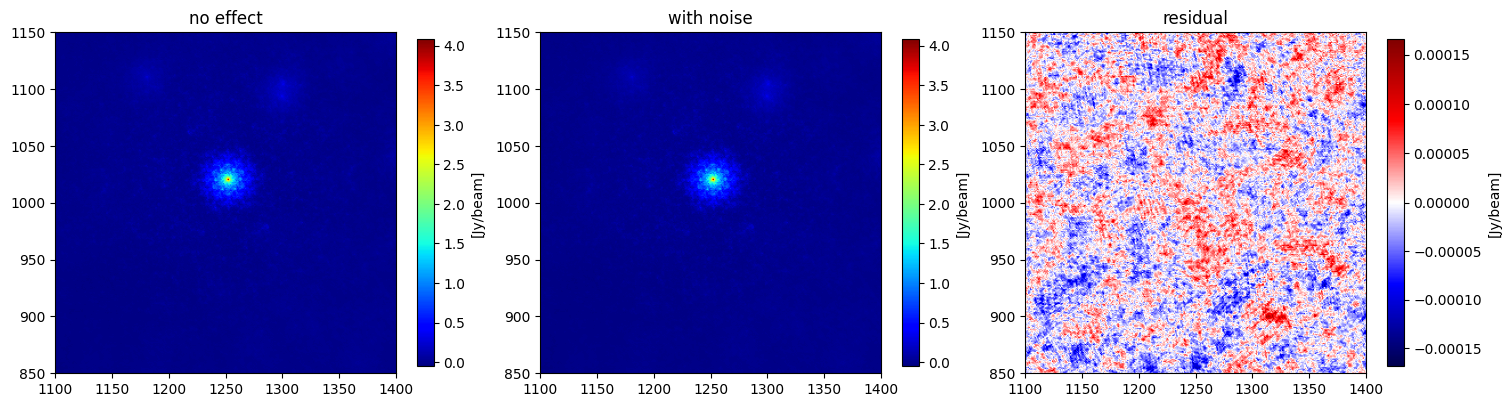

In [52]:
fig, axs = plt.subplots(figsize=(15, 10), ncols=3, nrows=1, constrained_layout=True)

axs[0].set_title('no effect')
im = axs[0].imshow(data, origin='lower', cmap='jet')
plt.colorbar(im, ax=axs[0], pad=0.01, fraction=0.048, label='[Jy/beam]')

axs[1].set_title('with noise')
im = axs[1].imshow(data_noise, origin='lower', cmap='jet')
plt.colorbar(im, ax=axs[1], pad=0.01, fraction=0.048, label='[Jy/beam]')

residual = data - data_noise
axs[2].set_title('residual')
im = axs[2].imshow(residual, origin='lower', cmap='seismic', norm=MidpointNormalize(vmin=residual.min(), midpoint=0, vmax=residual.max()))
plt.colorbar(im, ax=axs[2], pad=0.01, fraction=0.048, label='[Jy/beam]')

for ax in axs: ax.set_xlim(1100, 1400), ax.set_ylim(850, 1150)

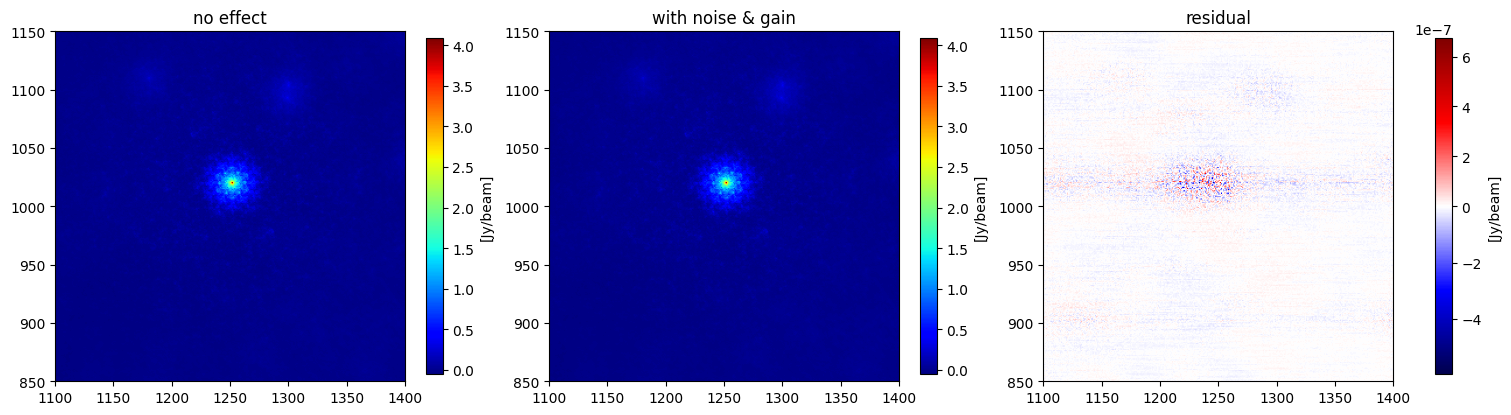

In [54]:
fig, axs = plt.subplots(figsize=(15, 10), ncols=3, nrows=1, constrained_layout=True)

axs[0].set_title('no effect')
im = axs[0].imshow(data, origin='lower', cmap='jet')
plt.colorbar(im, ax=axs[0], pad=0.01, fraction=0.048, label='[Jy/beam]')

axs[1].set_title('with noise & gain')
im = axs[1].imshow(data_gain, origin='lower', cmap='jet')
plt.colorbar(im, ax=axs[1], pad=0.01, fraction=0.048, label='[Jy/beam]')

residual = data - data_gain
axs[2].set_title('residual')
im = axs[2].imshow(residual, origin='lower', cmap='seismic', norm=MidpointNormalize(vmin=residual.min(), midpoint=0, vmax=residual.max()))
plt.colorbar(im, ax=axs[2], pad=0.01, fraction=0.048, label='[Jy/beam]')

for ax in axs: ax.set_xlim(1100, 1400), ax.set_ylim(850, 1150)